### Decision Trees Video walk through and Random Forests Assignment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import plot_tree

- *Decision Trees*

Structure: A decision tree is a flowchart-like structure where each internal node represents a decision based on a feature, each branch represents an outcome of the decision, and each leaf node represents a class label or a continuous value (for regression).

1) **Algorithm**: The algorithm for a decision tree involves splitting the data at each node based on the feature that results in the highest information gain or the best reduction in impurity (like Gini impurity or entropy).

2) **Interpretability**: Decision trees are often praised for their interpretability. You can visualize the tree and understand the decision-making process by tracing the path from the root to a leaf.

3) **Overfitting**: Decision trees are prone to ***overfitting***, especially if they grow too deep and become too complex. They can capture noise in the training data, leading to poor generalization on unseen data.

4) **Complexity**: Decision trees can be relatively simple or complex, depending on how they are constructed. They may not perform well if the data has a lot of variance or if the relationships between features and target variables are complex.

- *Random Forests*

Structure: A random forest is an ensemble learning method that builds multiple decision trees (hence "forest") and combines their predictions. Each tree in the forest is built using a subset of the data and a random subset of features.

1) **Algorithm**: In random forests, each tree is trained on a random subset of the data with replacement (bootstrap sampling). Additionally, at each split, a random subset of features is considered for splitting. The final prediction is made by aggregating the predictions of all individual trees, usually by majority voting (for classification) or averaging (for regression).

2) **Interpretability**: Random forests are less interpretable than single decision trees because they aggregate the results of many trees. Understanding how individual predictions are made is more complex because it involves many trees working together.

3) **Overfitting**: Random forests are generally less prone to overfitting compared to individual decision trees. By averaging the predictions of many trees, random forests can reduce the variance and improve generalization to unseen data.

4) **Complexity**: Random forests are typically more complex and computationally intensive than individual decision trees, due to the need to build and maintain many trees and aggregate their results. However, they often perform better on a wide range of problems.

While a decision tree provides a straightforward model with a clear decision-making process, a random forest offers improved performance and robustness by leveraging multiple decision trees and aggregating their predictions.

In [2]:
# Reading the dataset
df = pd.read_parquet('final_dataset.parquet')

# Replacing NaN values with 0
df = df.fillna(0)

# 4881 rows × 9 columns

In [3]:
df.head()

# note that cfs stands for cubic feet/person 
# gwl stands for ground water level 
# 4881 rows × 9 columns

,date,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_pca,st_pca,target
0,2010-02-14,0.0,36,13,20.52,136.0,3.619512,0.190574,0
1,2010-02-15,0.0,41,7,20.51,129.0,3.470118,0.209177,0
2,2010-02-16,0.0,43,8,20.51,130.0,3.433721,0.197542,0
3,2010-02-17,0.0,51,10,20.51,132.0,3.351107,0.135033,0
4,2010-02-18,0.0,51,16,20.50,135.0,3.238121,0.107690,0


**Figuring out exactly what years the droughts occur**

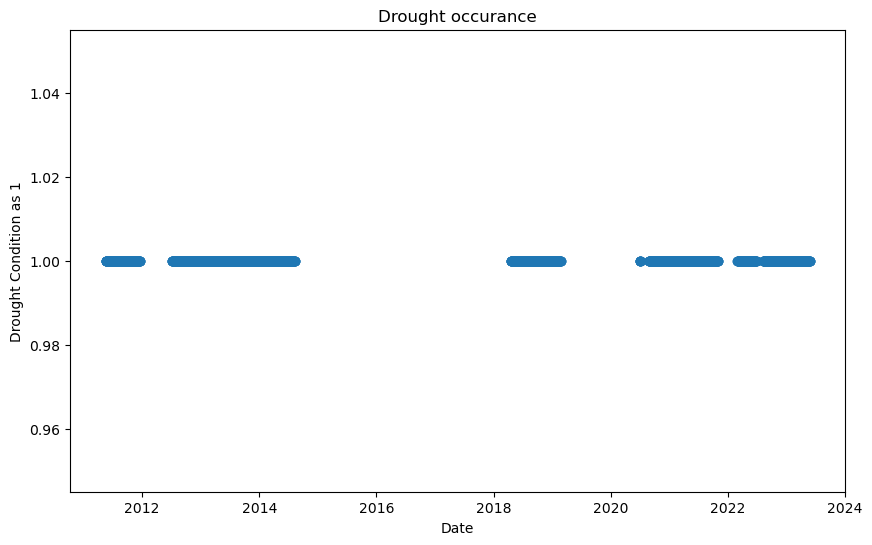

In [4]:
# Visualizing where target variable is 1 i.e there is drought

plt.figure(figsize=(10, 6))
plt.scatter(df[df['target'] == 1]['date'], df[df['target'] == 1]['target'])
plt.title('Drought occurance')
plt.xlabel('Date')
plt.ylabel('Drought Condition as 1')
plt.show()


Listing all our **features**, including the 2 features obtained from PCA `sm_pca` and `st_pca` (See PCA lectures) 

In [5]:
# following are the features list

features = ['precip', 'max_temp', 'min_temp', 'gwl', 'daily_discharge_cfs','sm_pca', 'st_pca']

# target is target
target = 'target'

**What is multi-collinearity?**

**Multicollinearity** occurs when two or more features (independent variables) in a regression model are highly correlated with each other. This means that these features provide redundant information about the variance in the dependent variable. When multicollinearity is present, it can make it difficult to assess the individual effect of each feature on the dependent variable because their effects are intertwined. It can be detected using various methods, including: *Correlation Matrix*: Examining the pairwise correlation coefficients between features.

In [6]:
# Checking for multicollinearity between features

corr = df[features].corr()
corr.style.background_gradient(cmap='coolwarm')


,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_pca,st_pca
precip,1.000000,-0.032593,0.104749,-0.024576,0.206089,-0.024596,-0.001298
max_temp,-0.032593,1.000000,0.861268,0.063881,0.010227,-0.390845,-0.302978
min_temp,0.104749,0.861268,1.000000,0.046226,0.101598,-0.406750,-0.333921
gwl,-0.024576,0.063881,0.046226,1.000000,-0.056801,0.019720,-0.452011
daily_discharge_cfs,0.206089,0.010227,0.101598,-0.056801,1.000000,0.024787,0.018521
sm_pca,-0.024596,-0.390845,-0.406750,0.019720,0.024787,1.000000,0.312463
st_pca,-0.001298,-0.302978,-0.333921,-0.452011,0.018521,0.312463,1.000000


We can see that there is ***correlation*** between `max_temp` and `min_temp`, but as per the domain knowledge, we know that these two features are important and we should keep them.

In [7]:
# Displaying the data before splitting

# display features 
display(df[features].head())

# display target
display(df[[target]].head())

,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_pca,st_pca
0,0.0,36,13,20.52,136.0,3.619512,0.190574
1,0.0,41,7,20.51,129.0,3.470118,0.209177
2,0.0,43,8,20.51,130.0,3.433721,0.197542
3,0.0,51,10,20.51,132.0,3.351107,0.135033
4,0.0,51,16,20.50,135.0,3.238121,0.107690


,target
0,0
1,0
2,0
3,0
4,0


**Why split data into training and testing sets?**

Splitting data into ***training*** and ***testing*** sets is a fundamental practice in machine learning to ensure that the model you build generalizes well to new, unseen data. The slit is important based upon:

1) **Assess Model Performance**: The training set is used to **fit the model**, while the testing set is used to **evaluate its performance**. This separation allows you to gauge how well the model will perform on new, unseen data, which is crucial for understanding its predictive power.

2) **Avoid Overfitting**: Overfitting occurs when a model performs exceptionally well on the training data but poorly on unseen data because it has essentially memorized the training examples rather than learning the underlying patterns. By evaluating the model on a separate testing set, you can detect overfitting and make adjustments.

3) **Estimate Generalization Error**: The testing set provides an estimate of the model’s generalization error, which is the error rate on data it has not been trained on. This estimate helps in comparing different models or tuning hyperparameters to find the best-performing model.

4) **Validate Model Assumptions**: The testing set can help you validate the assumptions about the model. For instance, if a model performs poorly on the test set, it may indicate issues such as incorrect feature selection or a need for more data.

5) **Benchmarking**: Splitting the data allows you to benchmark your model’s performance against other models or baseline methods. This is essential for understanding the relative effectiveness of different approaches.

6) **Hyperparameter** Tuning: When tuning hyperparameters, it’s important to use a separate validation set (often derived from the training set) to evaluate different parameter settings before testing the final model on the untouched test set. This helps ensure that the final model is optimized and less likely to overfit.

Splitting data into training and testing sets is crucial for developing reliable and generalizable machine learning models. It helps ensure that your model performs well not just on the data it was trained on, but **also on new data it hasn’t seen before**. Testing, depending on the test is usually done as a **70/30 split**. There is no univerisal rule to this and I like to say, it is "research specific."

In [8]:
# Splitting up into training and testing tests for the feature sets and target sets

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.2, random_state = 0)

In [9]:
# No. of instance with 1 in target variable for training set
display(y_train.value_counts())

# No. of instance with 1 in target variable for test set
display(y_test.value_counts())

target
0    2218
1    1686
Name: count, dtype: int64

target
0    536
1    441
Name: count, dtype: int64

In [10]:
# display the data after splitting

# Training set
display(pd.DataFrame(X_train).head())   # for the feature 
display(pd.DataFrame(y_train).head())   # for the target 

# Test set
display(pd.DataFrame(X_test).head())   # for the feature 
display(pd.DataFrame(y_test).head())   # for the target 

,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_pca,st_pca
641,0.00,57,11,21.00,145.0,0.494067,-1.976446
333,0.11,35,19,20.84,93.7,-0.995163,0.067906
33,0.08,40,25,20.44,120.0,-0.179378,1.826560
3909,0.00,41,8,21.71,96.9,-0.002604,1.751204
4193,0.00,62,32,22.13,150.0,0.943268,-1.191578


,target
641,1
333,0
33,0
3909,1
4193,1


,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_pca,st_pca
2857,0.01,47,22,21.16,170.0,2.224886,2.490720
2373,0.00,75,30,21.73,100.0,0.893778,-1.718663
1065,0.00,48,17,21.00,78.3,0.303675,0.066434
2287,0.00,97,60,21.31,112.0,-0.647494,-0.541322
1675,0.00,80,42,21.45,163.0,-0.127969,-1.816134


,target
2857,0
2373,0
1065,1
2287,0
1675,0


In [11]:
# Scaling the features
# Feature scaling is performed to ensure that the model is not biased towards the features with higher magnitude

sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [12]:
# Displaying the scaled training set

display(pd.DataFrame(X_train).head())

,0,1,2,3,4,5,6
0,-0.236413,-0.703677,-1.472493,-0.789317,-0.043247,0.398965,-1.188105
1,0.574686,-1.801402,-1.034528,-1.157828,-0.211894,-0.693305,0.026048
2,0.353477,-1.551919,-0.706055,-2.079106,-0.125433,-0.094971,1.070523
3,-0.236413,-1.502023,-1.636730,0.845953,-0.201374,0.034684,1.025768
4,-0.236413,-0.454194,-0.322836,1.813295,-0.026809,0.728431,-0.721967


In [13]:
# Implementing decision tree classifier

classifier = DecisionTreeClassifier(random_state = 0)
classifier.fit(X_train, y_train)  # on the training set 

preds = classifier.predict(sc.transform(X_test))  # applying it to the testing for prediction (scaling our testing set as well)

In [14]:
# binary classification 
preds

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,

What does the confusion matrix tell us for Decision Tree Classifiers? 

A **confusion matrix** is a valuable tool for evaluating the performance of a decision tree classifier, or any classification model. It provides a detailed breakdown of how well the model is performing across different classes. Here’s what you can learn from it:

1) **True Positives (TP)**: The number of instances correctly classified as a positive class. For example, if your decision tree is classifying whether an email is spam, TP would be the number of spam emails correctly identified as spam. Also known as Recall or Sensitivity.

2) **True Negatives (TN)**: The number of instances correctly classified as a negative class. In the spam email example, TN would be the number of non-spam emails correctly identified as non-spam.

3) **False Positives (FP)**: The number of instances incorrectly classified as a positive class. In the spam example, FP would be the number of non-spam emails incorrectly identified as spam.

4) **False Negatives (FN)**: The number of instances incorrectly classified as a negative class. For the spam email case, FN would be the number of spam emails incorrectly identified as non-spam.

What metrics can we calculate from this? 

***Accuracy*** — **(TP + TN) / (TP + TN + FP + FN)** — The proportion of correctly classified instances out of the total instances.

***Precision*** — **TP / (TP + FP)** — The proportion of true positives among the instances classified as positive. It indicates how many of the positive classifications were actually correct.

***Recall (Sensitivity or True Positive Rate)*** — **TP / (TP + FN)** — The proportion of actual positives that were correctly identified. It tells you how well the model identifies positive instances. 


***F1 Score*** — **2 * (Precision * Recall) / (Precision + Recall)** — The harmonic mean of precision and recall, providing a balance between them. It’s useful when you need to balance precision and recall.


***Specificity (True Negative Rate)***: **TN / (TN + FP)** — The proportion of actual negatives that were correctly identified. It measures how well the model identifies negative instances.

***False Positive Rate*** **FP / (FP + TN)** — The proportion of actual negatives that were incorrectly classified as positive.

***False Negative Rate*** **FN / (FN + TP)** — The proportion of actual positives that were incorrectly classified as negative.


All in all, the *confusion matrix* helps you understand where your decision tree classifier is making errors, whether it’s more prone to false positives or false negatives, and provides a comprehensive view of the model’s performance across different classes. This information can guide you in tuning the model or choosing appropriate metrics based on the specific application needs.

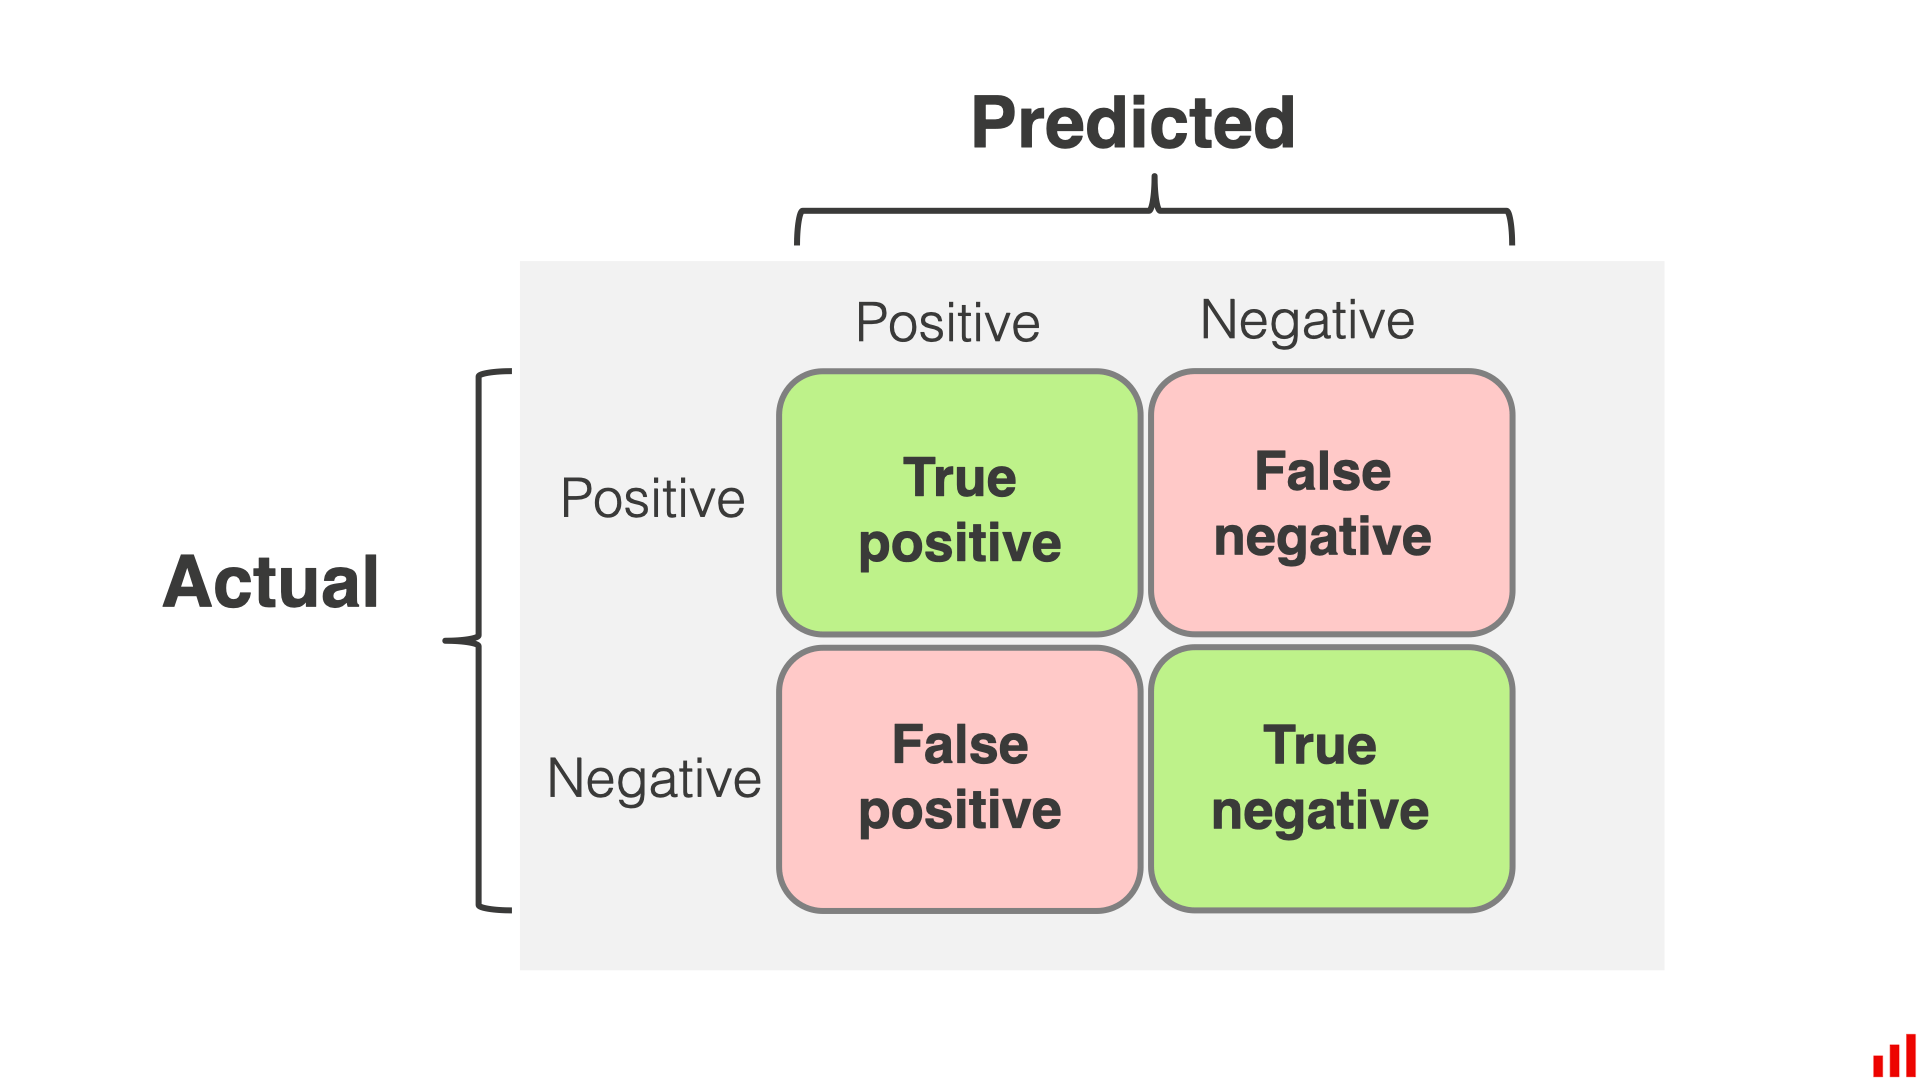

In [15]:
from IPython.display import Image, display

# Display the image
display(Image(filename='confusion_matrix.png'))

Text(0.5, 1.0, 'Confusion Matrix for Decision Tree Classifier')

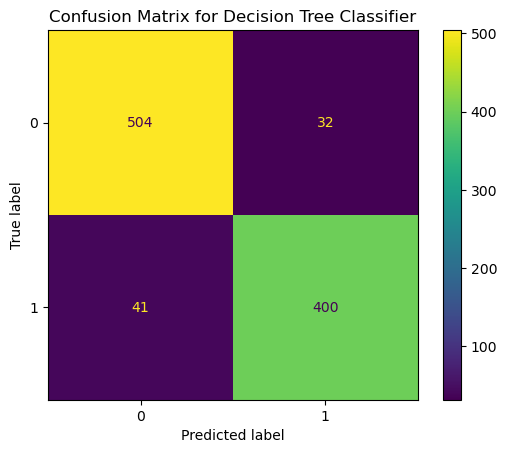

In [16]:
# Generating the confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score

cm = confusion_matrix(y_test, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
disp.ax_.set_title('Confusion Matrix for Decision Tree Classifier')

In [17]:
# Accuracy, F1 Score and Recall Score

accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
recall = recall_score(y_test, preds)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall Score: {recall}')

Accuracy: 0.925281473899693
F1 Score: 0.9163802978235969
Recall Score: 0.9070294784580499


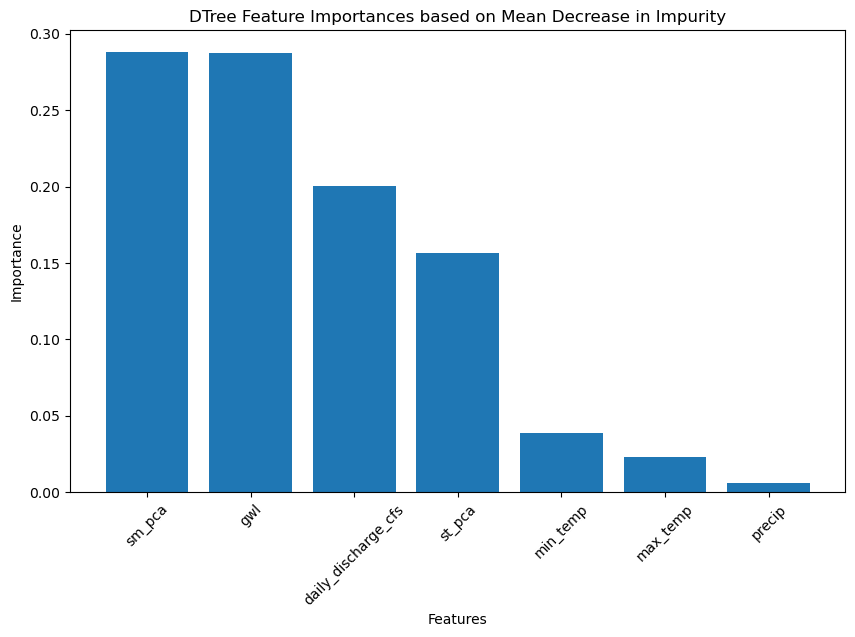

In [18]:
# visualizing the feature importance

importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("DTree Feature Importances based on Mean Decrease in Impurity")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

For your programming Assignment, you will repeat these steps but instead implement the `Random Forest` Clasifier. 